In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def run_simulation(
    J=5,        # Number of AI models
    I=30000,    # Vocabulary size
    T=60,       # Number of time steps (months)
    retrain_period=2,
    H_0=1.0,    # Initial human content
    G_0=0.1,    # Initial AI content
    c=0.07,     # Human base production rate
    d=0.015,    # Human exponential growth rate (lowered for realism)
    a_total=0.15, # Total AI production rate
    b_total=0.025, # Total AI exponential growth rate (lowered for realism)
    F_j=None,    # Filtering per model
    sample_size=10000,
    top_p=0.9,
    tail_fraction=0.2,
    alpha=1.0,
    memory_frac=0.2
):
    if F_j is None:
        F_j = np.array([0.85, 0.9, 0.7, 0.0, 0.95])[:J]
    else:
        F_j = np.array(F_j)[:J]

    ranks = np.arange(1, I+1)
    q_i = 1 / np.power(ranks, alpha)
    q_i = q_i / np.sum(q_i)
    p_ij = np.random.dirichlet(np.ones(I), size=J)
    p_history = np.zeros((T, J, I))
    p_history[0] = p_ij.copy()
    H_history = [H_0]
    G_history = [G_0]
    entropy_history = np.zeros((T, J))
    variance_history = np.zeros((T, J))

    def h(t): return c * np.exp(d * t)
    a_j = np.ones(J) * a_total / J
    b_j = np.ones(J) * b_total
    def g_j_func(t, j): return a_j[j] * np.exp(b_j[j] * t)
    def compute_R_i(t, p_history, q_i, H_0, G_0):
        H_t = H_0 + sum(h(s) for s in range(1, t+1))
        G_t = sum(sum(g_j_func(s, j) for j in range(J)) for s in range(1, t+1)) + G_0
        numerator = H_0 * q_i
        for s in range(1, t+1):
            numerator += h(s) * q_i
            for j in range(J):
                numerator += g_j_func(s, j) * p_history[s-1, j]
        R_i = numerator / (H_t + G_t)
        return R_i, H_t, G_t
    def entropy(p): return -np.sum(p[p > 0] * np.log2(p[p > 0]))

    for j in range(J):
        entropy_history[0, j] = entropy(p_ij[j])
        variance_history[0, j] = np.var(p_ij[j])

    for t in range(1, T):
        R_i, H_t, G_t = compute_R_i(t, p_history, q_i, H_0, G_0)
        H_history.append(H_t)
        G_history.append(G_t)
        for j in range(J):
            if t % retrain_period == 0:
                internet_mixture = F_j[j] * q_i + (1 - F_j[j]) * R_i
                internet_mixture /= internet_mixture.sum()
                sorted_idx = np.argsort(-internet_mixture)
                cumulative = np.cumsum(internet_mixture[sorted_idx])
                cutoff_idx = np.searchsorted(cumulative, top_p)
                allowed = sorted_idx[:cutoff_idx+1]
                filtered_probs = np.zeros_like(internet_mixture)
                filtered_probs[allowed] = internet_mixture[allowed]
                filtered_probs /= filtered_probs.sum()
                samples = np.random.choice(I, size=sample_size, p=filtered_probs)
                freq = np.bincount(samples, minlength=I) / sample_size
                prev = p_history[t-1, j]
                # Blend with previous state for 'memory'
                p_history[t, j] = (1 - memory_frac) * freq + memory_frac * prev
                p_history[t, j] /= p_history[t, j].sum()
            else:
                p_history[t, j] = p_history[t-1, j]
            entropy_history[t, j] = entropy(p_history[t, j])
            variance_history[t, j] = np.var(p_history[t, j])

    loss_threshold = 1e-8
    human_token_indices = np.where(q_i > 0)[0]
    num_human = len(human_token_indices)
    percent_lost_human_matrix = np.zeros((T, J))
    for t in range(T):
        for j in range(J):
            percent_lost_human_matrix[t, j] = (
                np.sum(p_history[t, j, human_token_indices] < loss_threshold) / num_human * 100
            )
    num_tail = int(I * tail_fraction)
    tail_indices = np.argsort(q_i)[:num_tail]
    percent_lost_tail_matrix = np.zeros((T, J))
    for t in range(T):
        for j in range(J):
            percent_lost_tail_matrix[t, j] = (
                np.sum(p_history[t, j, tail_indices] < loss_threshold) / num_tail * 100
            )
    return {
        "H_history": H_history,
        "G_history": G_history,
        "entropy_history": entropy_history,
        "variance_history": variance_history,
        "percent_lost_human_matrix": percent_lost_human_matrix,
        "percent_lost_tail_matrix": percent_lost_tail_matrix,
        "q_i": q_i
    }


In [4]:
def print_simulation_metrics(results, label, J=5):
    print(f"\n--- {label} ---")
    final_month = len(results["H_history"]) - 1
    print(f"Final Month: {final_month}")
    print(f"Human Content H(T): {results['H_history'][-1]:.2f}")
    print(f"AI Content G(T): {results['G_history'][-1]:.2f}")
    ratio = results['G_history'][-1] / results['H_history'][-1]
    print(f"AI/Human Content Ratio: {ratio:.2f}")
    print("\nEntropy per AI Model (final month):")
    for j in range(min(J, results['entropy_history'].shape[1])):
        print(f"  Model {j+1}: {results['entropy_history'][-1, j]:.4f}")
    print(f"Human Entropy: { -np.sum(results['q_i'][results['q_i'] > 0] * np.log2(results['q_i'][results['q_i'] > 0])):.4f}")
    print("\nVariance per AI Model (final month):")
    for j in range(min(J, results['variance_history'].shape[1])):
        print(f"  Model {j+1}: {results['variance_history'][-1, j]:.4f}")
    print(f"Human Variance: {np.var(results['q_i']):.4f}")
    print("\nPercent Human Tokens Lost (final month):")
    for j in range(min(J, results['percent_lost_human_matrix'].shape[1])):
        print(f"  Model {j+1}: {results['percent_lost_human_matrix'][-1, j]:.2f}%")
    print("\nPercent Tail Words Lost (final month):")
    for j in range(min(J, results['percent_lost_tail_matrix'].shape[1])):
        print(f"  Model {j+1}: {results['percent_lost_tail_matrix'][-1, j]:.2f}%")


In [5]:
def compare_metric_over_time(results_list, metric_name, labels, ylabel, title):
    plt.figure(figsize=(10, 6))
    for res, label in zip(results_list, labels):
        if metric_name == "AI/Human Ratio":
            ratio = np.array(res["G_history"]) / np.array(res["H_history"])
            plt.plot(ratio, label=label)
        elif metric_name == "Entropy (Model 1)":
            plt.plot(res["entropy_history"][:, 0], label=label)
        elif metric_name == "Percent Human Tokens Lost (Model 1)":
            plt.plot(res["percent_lost_human_matrix"][:, 0], label=label)
        elif metric_name == "Percent Tail Words Lost (Model 1)":
            plt.plot(res["percent_lost_tail_matrix"][:, 0], label=label)
    plt.xlabel('Time Step (Month)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



--- Baseline ---
Final Month: 59
Human Content H(T): 7.69
AI Content G(T): 20.58
AI/Human Content Ratio: 2.68

Entropy per AI Model (final month):
  Model 1: 9.1246
  Model 2: 9.0777
  Model 3: 8.9582
  Model 4: 8.7797
  Model 5: 9.1117
Human Entropy: 10.4768

Variance per AI Model (final month):
  Model 1: 0.0000
  Model 2: 0.0000
  Model 3: 0.0000
  Model 4: 0.0000
  Model 5: 0.0000
Human Variance: 0.0000

Percent Human Tokens Lost (final month):
  Model 1: 76.69%
  Model 2: 76.53%
  Model 3: 78.33%
  Model 4: 84.05%
  Model 5: 75.97%

Percent Tail Words Lost (final month):
  Model 1: 100.00%
  Model 2: 100.00%
  Model 3: 100.00%
  Model 4: 100.00%
  Model 5: 100.00%

--- Slow Growth, Strong Memory ---
Final Month: 59
Human Content H(T): 6.66
AI Content G(T): 14.44
AI/Human Content Ratio: 2.17

Entropy per AI Model (final month):
  Model 1: 9.7681
  Model 2: 9.8050
  Model 3: 9.7860
  Model 4: 9.7371
  Model 5: 9.8082
Human Entropy: 10.4768

Variance per AI Model (final month):
  Mo

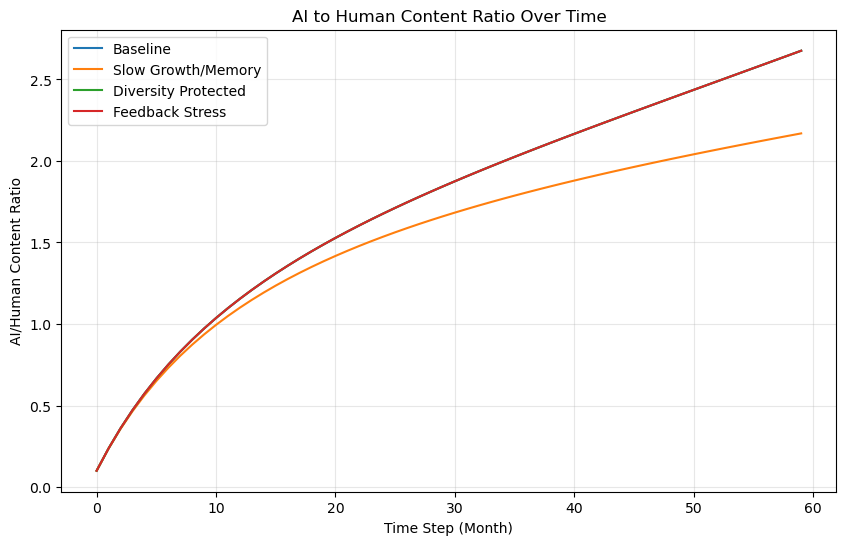

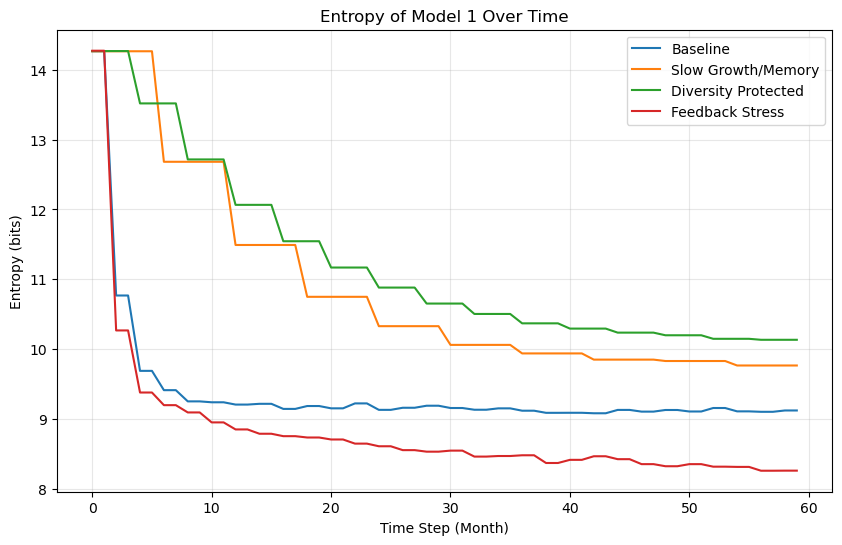

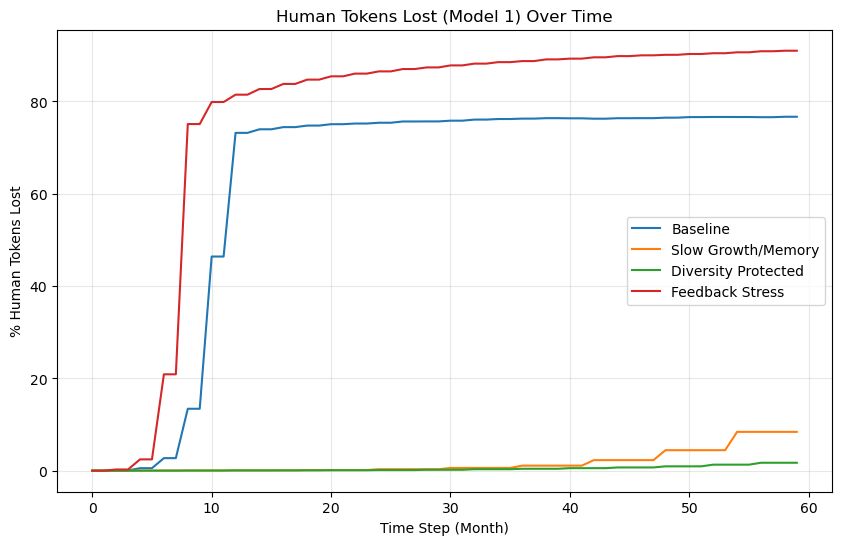

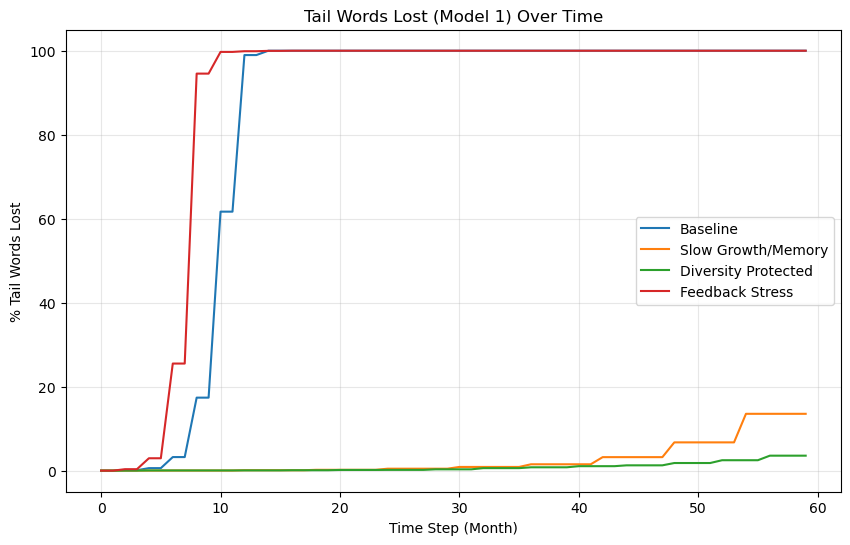

In [6]:
# Run all selected scenarios
results_baseline = run_simulation(
    J=5,
    F_j=[0.85, 0.9, 0.7, 0.0, 0.95],
    retrain_period=2,
    top_p=0.9,
    memory_frac=0.2
)

results_slow_growth_memory = run_simulation(
    J=5,
    d=0.01,
    b_total=0.015,
    retrain_period=6,
    F_j=[0.9, 0.92, 0.94, 0.95, 0.93],
    top_p=0.95,
    memory_frac=0.5
)

results_high_filter_high_memory = run_simulation(
    J=5,
    F_j=[1.0, 1.0, 1.0, 1.0, 1.0],
    retrain_period=4,
    top_p=0.99,
    memory_frac=0.7
)

results_low_filter_weak_memory = run_simulation(
    J=5,
    F_j=[0.4, 0.55, 0.6, 0.2, 0.5],
    retrain_period=2,
    top_p=0.85,
    memory_frac=0.1
)

# Print metrics for each
print_simulation_metrics(results_baseline, "Baseline", J=5)
print_simulation_metrics(results_slow_growth_memory, "Slow Growth, Strong Memory", J=5)
print_simulation_metrics(results_high_filter_high_memory, "Diversity Protected", J=5)
print_simulation_metrics(results_low_filter_weak_memory, "High Feedback Stress", J=5)

# Compare visually with the first model from each scenario
results_list = [
    results_baseline,
    results_slow_growth_memory,
    results_high_filter_high_memory,
    results_low_filter_weak_memory
]
labels = [
    "Baseline",
    "Slow Growth/Memory",
    "Diversity Protected",
    "Feedback Stress"
]

compare_metric_over_time(results_list, "AI/Human Ratio", labels, "AI/Human Content Ratio", "AI to Human Content Ratio Over Time")
compare_metric_over_time(results_list, "Entropy (Model 1)", labels, "Entropy (bits)", "Entropy of Model 1 Over Time")
compare_metric_over_time(results_list, "Percent Human Tokens Lost (Model 1)", labels, "% Human Tokens Lost", "Human Tokens Lost (Model 1) Over Time")
compare_metric_over_time(results_list, "Percent Tail Words Lost (Model 1)", labels, "% Tail Words Lost", "Tail Words Lost (Model 1) Over Time")
